In [1]:
import numpy as np
import glob
import os 
import cv2
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, Conv3DTranspose,BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

## My architecture


In [2]:
# Simple Sequential Model - Easy to understand and modify
model = Sequential()

# Encoder layers
model.add(Conv3D(filters=64, kernel_size=(7,7,1), strides=(2,2,1), padding='same', input_shape=(232,232,10,1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv3D(filters=128, kernel_size=(5,5,1), strides=(2,2,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv3D(filters=256, kernel_size=(3,3,1), strides=(2,2,1), padding='same', activation='relu'))
model.add(BatchNormalization())

# Temporal processing with ConvLSTM2D
# Note: Conv3D output needs reshaping for ConvLSTM2D
model.add(Reshape((-1, 29, 29, 256)))  # Reshape to (time, height, width, channels)
model.add(ConvLSTM2D(filters=256, kernel_size=(3,3), padding='same',dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(ConvLSTM2D(filters=128, kernel_size=(3,3), padding='same',dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(ConvLSTM2D(filters=256, kernel_size=(3,3), padding='same',dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# Reshape back for Conv3DTranspose
model.add(Reshape((29, 29, 10, 256)))  # Back to (height, width, time, channels)
# Decoder layers
model.add(Conv3DTranspose(filters=128, kernel_size=(3,3,1), strides=(2,2,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv3DTranspose(filters=64, kernel_size=(5,5,1), strides=(2,2,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv3DTranspose(filters=32, kernel_size=(7,7,1), strides=(2,2,1), padding='same', activation='relu'))
# Output layer
model.add(Conv3D(filters=1, kernel_size=(3,3,1), padding='same', activation='tanh'))

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 116, 116, 10, 64)  3200      
                                                                 
 batch_normalization (BatchN  (None, 116, 116, 10, 64)  256      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 58, 58, 10, 128)   204928    
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 10, 128)  512       
 hNormalization)                                                 
                                                                 
 conv3d_2 (Conv3D)           (None, 29, 29, 10, 256)   295168    
                                                                 
 batch_normalization_2 (Batc  (None, 29, 29, 10, 256)  1

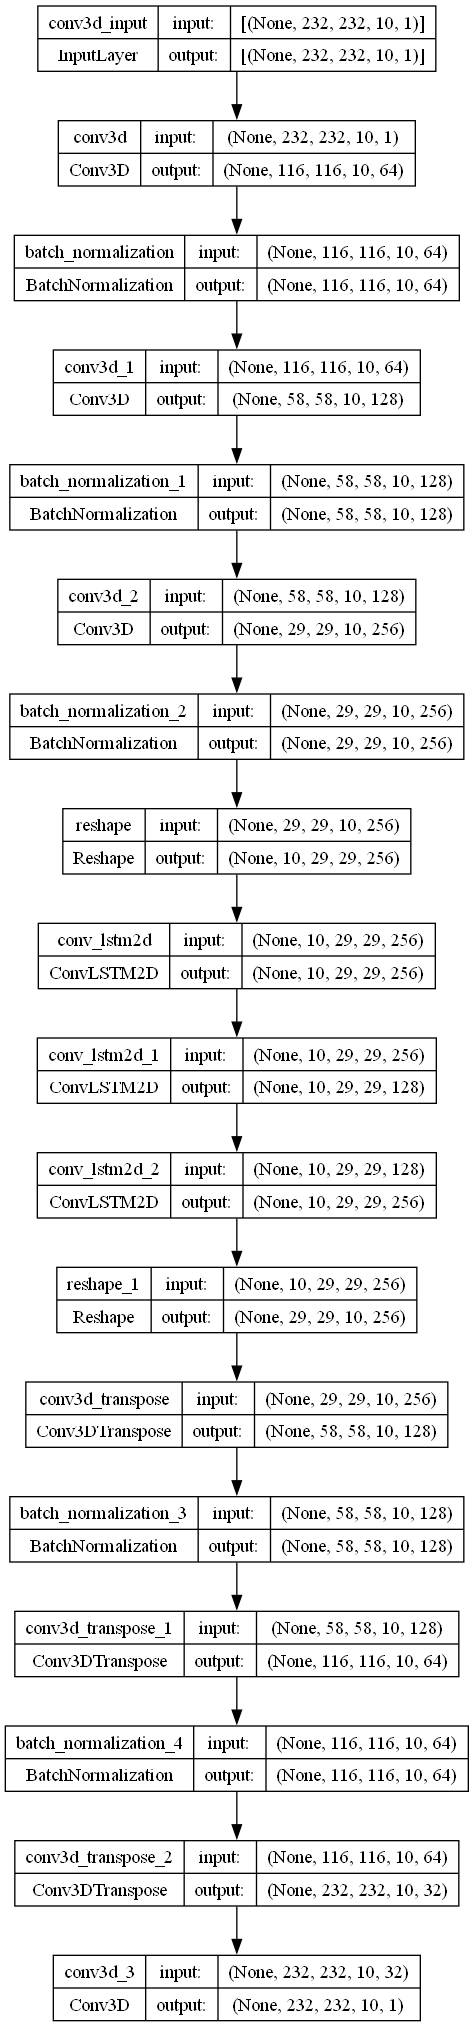

In [3]:
from keras.utils import plot_model
plot_model(model, to_file="modle_model_plot.png", show_shapes=True, show_layer_names=True)

In [4]:
# Custom loss for better localization
def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # Add small SSIM component if needed
    return mse_loss
model.compile(optimizer=Adam(learning_rate=0.001),loss=combined_loss,metrics=['mse', 'mae'])

In [5]:
#dataset loading
training_data=np.load('../dataset/training.npy') 
training_data.shape

(232, 232, 67)

In [6]:
frames=training_data.shape[2]
frames=frames-frames%10
training_data=training_data[:,:,:frames]

In [7]:
print(training_data.shape)
training_data.ndim

(232, 232, 60)


3

In [8]:
training_data=training_data.reshape(-1,232,232,10)

In [9]:
print(training_data.shape)
training_data.ndim

(6, 232, 232, 10)


4

In [10]:
training_data=np.expand_dims(training_data,axis=4)
print(training_data.shape)
training_data.ndim

(6, 232, 232, 10, 1)


5

In [11]:
target_data=training_data.copy()
epochs=10
batch_size=1
callback_save = ModelCheckpoint("../models/model.h5", monitor="loss", verbose = 1, save_best_only=True)
callback_early_stopping = EarlyStopping( monitor='loss', patience=5)
history = model.fit(training_data,target_data, batch_size=batch_size, epochs=epochs, callbacks = [callback_save,callback_early_stopping])

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.4377 - mse: 0.4377 - mae: 0.5381
Epoch 1: loss improved from inf to 0.43771, saving model to ../models\model.h5
6/6 [==============================] - 18s 1s/step - loss: 0.4377 - mse: 0.4377 - mae: 0.5381
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.2665 - mse: 0.2665 - mae: 0.4232
Epoch 2: loss improved from 0.43771 to 0.26645, saving model to ../models\model.h5
6/6 [==============================] - 7s 1s/step - loss: 0.2665 - mse: 0.2665 - mae: 0.4232
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.2137 - mse: 0.2137 - mae: 0.3824
Epoch 3: loss improved from 0.26645 to 0.21374, saving model to ../models\model.h5
6/6 [==============================] - 7s 1s/step - loss: 0.2137 - mse: 0.2137 - mae: 0.3824
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.1672 - mse: 0.1672 - mae: 0.3293
Epoch 4: loss improved from 0.21374 to 0.16717, saving model to ../mode

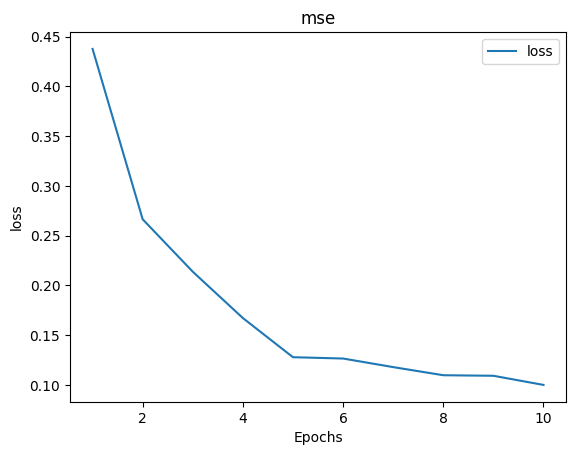

In [12]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="loss")
plt.title("mse")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
# plt.savefig("loss_graph_E10.jpeg")
plt.show()